In [349]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import tree 
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import plotly.express as px

sns.set_style('whitegrid')

In [350]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')

# Exploratory Data Analysis

In [351]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [352]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

#### Review Count Graph

Text(0.5, 1.0, 'Review Count by Rating')

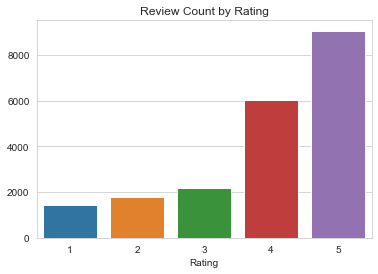

In [353]:
grouped = df.groupby('Rating')['Rating'].count()
sns.barplot(x = grouped.index, y = grouped.values).set_title('Review Count by Rating')

After plotting review count per rating, it is evident that there is a class imbalance. By group together ratings of 1 and 2, ratings of 3 and 4, and rating 5, the class imbalance should be reduced.

In [354]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['Rating'].apply(new_rating)

Text(0.5, 1.0, 'Grouped Review Count by Rating')

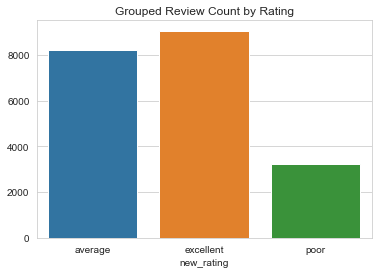

In [355]:
new_rating_grouped = df.groupby('new_rating')['Rating'].count()
new_rating_grouped
sns.barplot(x = new_rating_grouped.index, y = new_rating_grouped.values).set_title('Grouped Review Count by Rating')

The class imbalance is less prominent now, but there are still less "poor" review types. This will be accounted for later.

#### Word Count Graph

Text(0.5, 1.0, 'Word Count by Review')

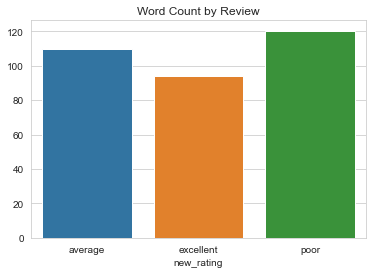

In [356]:
df['words'] = [x.split() for x in df['Review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

This graph shows that the larger the word count, the worse the review. It is worth considering including this feature in the modeling process.

# Preprocessing

Functions will be used on the "Reviews" column in order to prepare the data for modeling.

In [357]:
sw = stopwords.words('english')

In [358]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [359]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [360]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [361]:
df.head()

,Review,Rating,new_rating,words,word_count,tokenized
0,nice hotel expensive parking got good deal sta...,4,average,"[nice, hotel, expensive, parking, got, good, d...",87,nice hotel expensive parking get good deal sta...
1,ok nothing special charge diamond member hilto...,2,poor,"[ok, nothing, special, charge, diamond, member...",250,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,average,"[nice, rooms, not, 4*, experience, hotel, mona...",217,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,excellent,"[unique,, great, stay,, wonderful, time, hotel...",89,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,excellent,"[great, stay, great, stay,, went, seahawk, gam...",191,great stay great stay go seahawk game awesome ...


#### Word Cloud Visual

In [362]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    

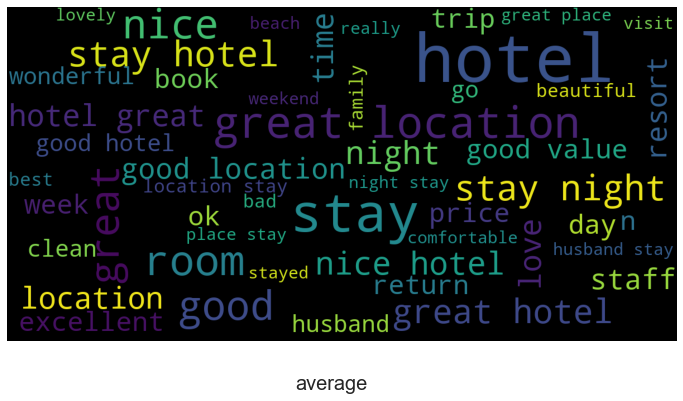

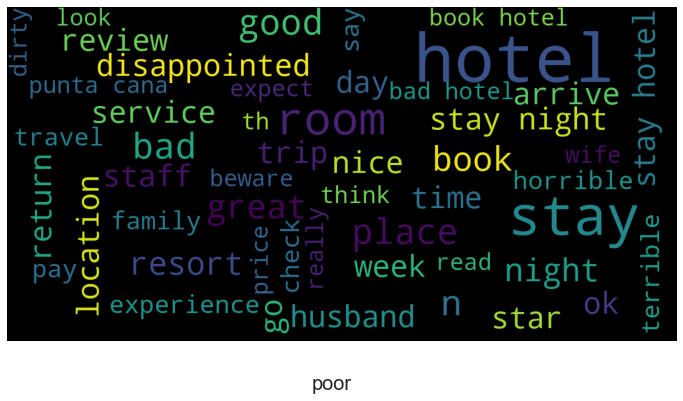

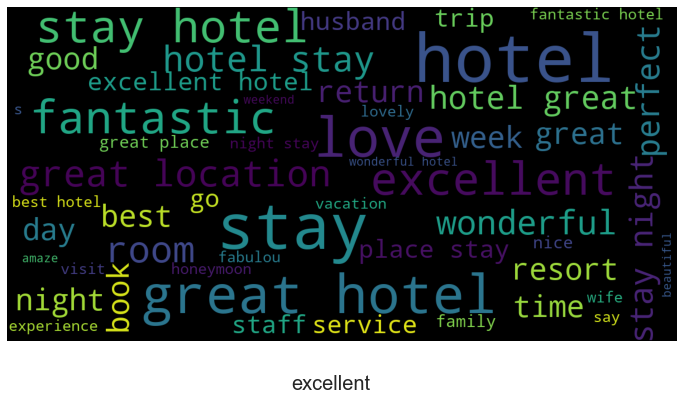

In [363]:
for rating in list(df['new_rating'].unique()):
    show_wordcloud(df[df['new_rating']==rating]['tokenized'], title=rating)

# Modeling

### Train Test Split

In [364]:
X = df['tokenized']
y = df['new_rating']

In [365]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)

### Vectorizing

In [441]:
tfidf_train = TfidfVectorizer(sublinear_tf=True, max_df=.8, min_df=.10,  ngram_range=(1, 1))

In [442]:
train_features = tfidf_train.fit_transform(X_train).toarray()
test_features = tfidf_train.transform(X_test).toarray()

In [443]:
pd.set_option('display.max_rows', None)

wm = tfidf_train.fit_transform(X_train)
tokens = tfidf_train.get_feature_names()

wm.shape
doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
data = pd.DataFrame(data=wm.toarray(), index=doc_names,
                  columns=tokens)
data.mean().sort_values()

read              0.019752
sure              0.020883
end               0.021041
open              0.021448
wait              0.021570
help              0.021626
long              0.022157
worth             0.022199
tell              0.022498
feel              0.022741
room clean        0.022808
size              0.023139
airport           0.023277
eat               0.023873
staff friendly    0.023915
shop              0.023920
money             0.024072
know              0.024110
overall           0.024124
locate            0.024926
hour              0.025010
travel            0.025036
th                0.025065
include           0.025173
morning           0.025301
expect            0.025670
year              0.025714
lobby             0.025910
week              0.025983
buffet            0.025983
door              0.026110
arrive            0.026126
stay hotel        0.026480
old               0.026530
drink             0.026669
star              0.026670
shower            0.026870
g

### PCA

In [444]:
pca = PCA(n_components=0.9, random_state=1)

pca_train = pca.fit_transform(train_features)
pca_test = pca.transform(test_features)

In [445]:
pca.n_components_

107

In [457]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(train_features)

pca1 = pca_result[:,0]
pca2 = pca_result[:,1] 
pca3 = pca_result[:,2]

pca1

array([-0.1147243 ,  0.0698958 ,  0.00713707, ...,  0.01914995,
       -0.14442198,  0.16334981])

In [458]:
# corpus_processed['rating']=pd.Categorical(corpus_processed['rating'])
#df['new_rating']
target = pd.Categorical(y_train).codes
target

array([1, 0, 1, ..., 1, 1, 1], dtype=int8)

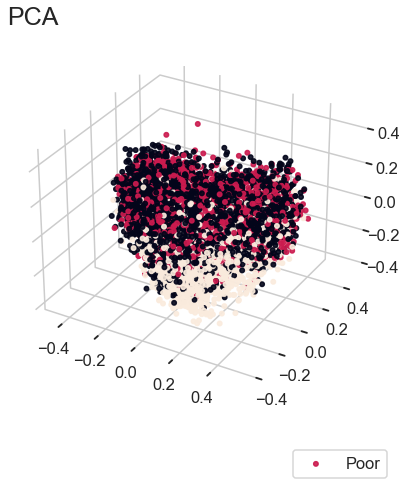

In [469]:

fig = plt.figure(figsize=(19, 7))

# plot PCA
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('PCA', fontsize=25, loc='left')
ax.scatter(xs=pca1, 
           ys=pca2, 
           zs=pca3, 
           c=target,
           alpha=.9,)
           # cmap=sns.color_palette(palette = "Blues", n_colors=2))

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# ax.legend(['Poor','Average','Excellent'])

ax.legend(['Poor','Average','Excellent'], bbox_to_anchor=(1.02, -0.08))


In [480]:
def visulize_w_grams(data_token_class, n=2):
    ratings = ['Poor', 'Average', 'Excellent']
    for i,tokens_by_class in enumerate(data_token_class):
        bigrams_series = (pd.Series(nltk.ngrams(tokens_by_class, n)).value_counts())[:20]
        bigrams_series.sort_values().plot.barh(width=.9, figsize=(10, 4))
        plt.title('20 Most Frequently Occurring in {}-grams of class {}-review'.format(n,ratings[i]), fontsize=18)
        plt.ylabel('{}-gram'.format(n), fontsize=18)
        plt.xlabel('Number of Occurances', fontsize=18)
        plt.show()

In [476]:
corpus_1 = df[df['new_rating']=='poor']
corpus_2 = df[df['new_rating']=='average']
corpus_3 = df[df['new_rating']=='excellent']

corpus_by_class = [corpus_1, corpus_2, corpus_3]

data_class = [df['tokenized'] for corpus in corpus_by_class]

tokens_by_class = []
for w_class in data_class:
    tokens_by_class.append([item for sublist in list(map(doc_preparer, w_class)) for item in sublist])

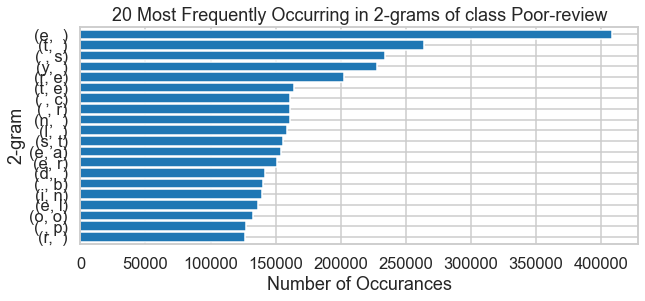

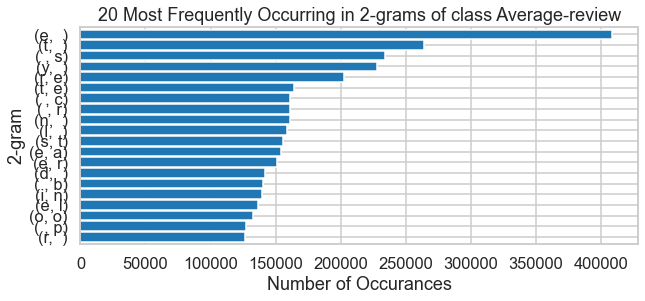

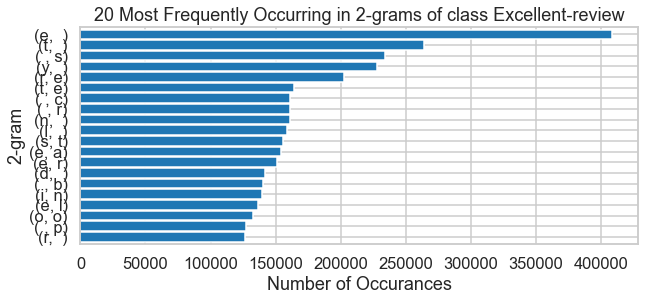

In [481]:
visulize_w_grams(tokens_by_class)

In [482]:
df_eda = pd.DataFrame()
df_eda['LEM']  = df.tokenized
df_eda['POS']  = df.tokenized.apply(lambda x: [pos_tag[1] for pos_tag in pos_tag(x)])     #<---pos-tagged tokens ("bag of tags")
df_eda['NOUN'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('NN')) / len(x) if len(x) > 0 else 0)   #<---percentage of nouns
df_eda['ADJ']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('JJ')) / len(x) if len(x) > 0 else 0)   #<---percentage of adjectives
df_eda['ADV']  = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('RB')) / len(x) if len(x) > 0 else 0)   #<---percentage of adverbs
df_eda['VERB'] = df_eda.POS.apply(
    lambda x: sum(1 for pos in x if pos.startswith('VB')) / len(x) if len(x) > 0 else 0)   #<---percentage of verbs
# structual features
df_eda['CHAR']    = df.Review.apply(lambda x: len(x))             #<---number of characters
df_eda['WORD']    = df.Review.apply(lambda x: len(x.split(' ')))  #<---number of words
df_eda['SENT']    = df.Review.apply(lambda x: len(x.split('. '))) #<---number of sentences
df_eda['LEN']     = df_eda.CHAR / df_eda.WORD                                  #<---average word length
df_eda['AVG']     = df_eda.WORD / df_eda.SENT                                  #<---average sentence length
df_eda['target'] = df['new_rating']

In [483]:
df_eda.head()

,LEM,POS,NOUN,ADJ,ADV,VERB,CHAR,WORD,SENT,COUNT,LEN,AVG,target
0,nice hotel expensive parking get good deal sta...,"[NN, NN, VBP, NN, NNP, NN, NN, NN, NN, NN, NNP...",0.680769,0.067308,0.000000,0.151923,593,89,1,0,6.662921,89.0,average
1,ok nothing special charge diamond member hilto...,"[JJ, NN, NNP, CC, JJ, NN, NN, JJ, VBP, JJ, NNP...",0.707865,0.072042,0.000000,0.131527,1689,252,1,0,6.702381,252.0,poor
2,nice room experience hotel monaco seattle good...,"[NN, NN, VBP, NN, NNP, NN, NN, IN, NN, NNP, NN...",0.705929,0.073518,0.000000,0.124111,1427,219,2,0,6.515982,109.5,average
3,unique great stay wonderful time hotel monaco ...,"[JJ, NN, NN, VBP, JJ, NN, NNP, NN, NN, VBZ, DT...",0.704251,0.079482,0.001848,0.129390,600,91,1,0,6.593407,91.0,excellent
4,great stay great stay go seahawk game awesome ...,"[NN, NN, VBZ, DT, NN, NNP, VBZ, VB, DT, NN, NN...",0.679091,0.076364,0.001818,0.136364,1281,193,2,0,6.637306,96.5,excellent


IndexError: index 2 is out of bounds for axis 0 with size 2

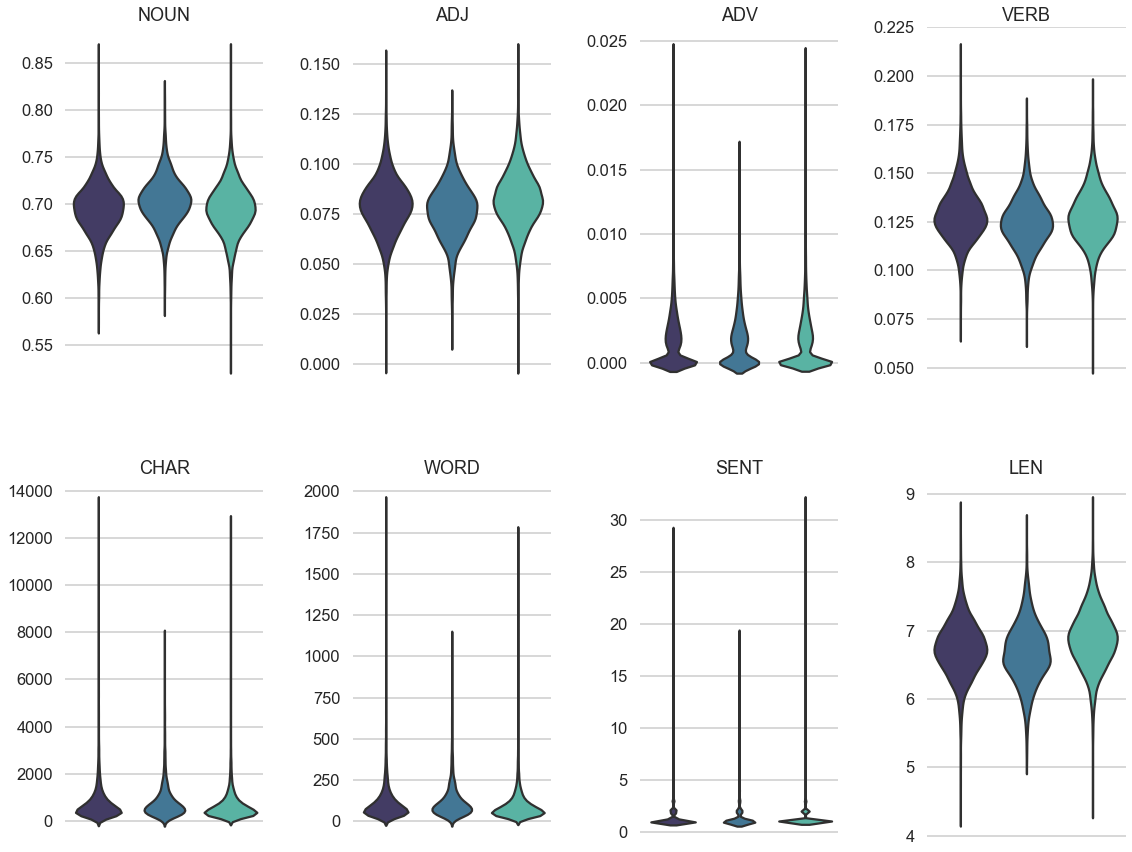

In [509]:
cols = ['TARGET','LEM','NOUN','ADJ','ADV','VERB','CHAR', 'WORD','SENT','LEN','AVG']

# plot feature distributions for helpful and unhelpful reviews
sns.set_style('whitegrid')
sns.set_context("talk")

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(19,15), facecolor='w')
plt.subplots_adjust(wspace=.45, hspace=.25)
sns.despine(bottom = True, left = True)


r = c = 0
for col in cols[2:]:
    sns.violinplot(data=df_eda, y=df_eda[col], x=df_eda.target,
                   ax=ax[r][c], legend_out = True,
                   inner=None, palette='mako').set_title(col)
    
# ax[r][c].set_ylim(ymin=None, ymax=df[col].quantile(.995))
    ax[r][c].set_xticks([])
    ax[r][c].set_xlabel('')
    ax[r][c].set_ylabel('')

    if c < 3:
        c += 1
    else:
        r += 1
        c = 0

ax.legend(labels=['poor','average','excellent'], bbox_to_anchor=(1.05, -0.05))

# plt.savefig(fname='images/density', bbox_inches='tight', pad_inches=0.1)
plt.show()

#error and how to show legend

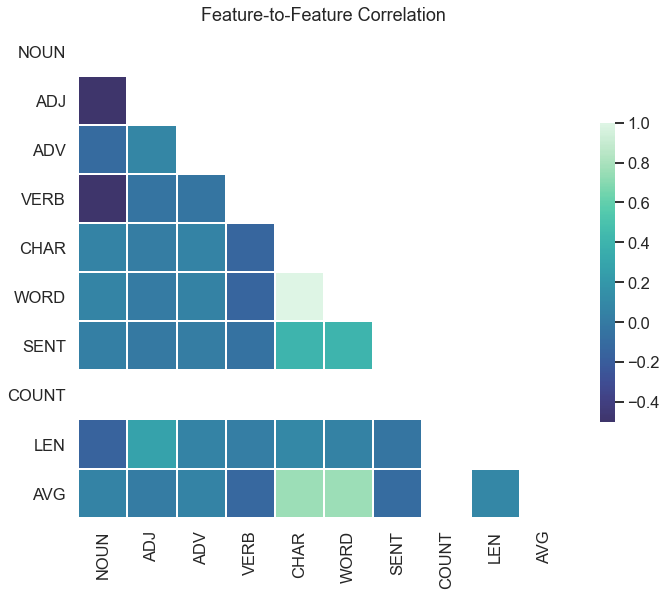

In [502]:

# plot pairwise correlations
sns.set_style('white')
sns.set_palette('dark:salmon')
sns.set_context("talk")

plt.figure(figsize=(11,11), facecolor='w')

sns.heatmap(
    df_eda.corr(),
    mask=np.triu(np.ones_like(df_eda.corr(), dtype=bool)),
    vmin=-0.5, vmax=1, center=0,
    square=True,
    linewidths=1,
    cmap="mako",
    cbar_kws={"shrink": 0.5}).set_title('Feature-to-Feature Correlation')

plt.show()



Creating a scoring function to call after each model.

In [372]:
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")
    

## Naive Bayes

In [373]:
scorer = make_scorer(f1_score, average='weighted')


In [374]:
params=  {'alpha': [0.09, 0.1,0.11]}

nb = MultinomialNB()

grid_search_nb = GridSearchCV(estimator = nb,scoring=scorer, param_grid = params, 
                          cv = 5, n_jobs = -1, verbose = 2)

#### Without PCA

In [375]:
grid_search_nb.fit(train_features, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.9s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [376]:
nb_train_preds = grid_search_nb.best_estimator_.predict(train_features)
nb_test_preds = grid_search_nb.best_estimator_.predict(test_features)
metrics_score(nb_train_preds, y_train, nb_test_preds, y_test)

Training Accuracy:	0.6201 	Testing Accuracy:	0.6248
Training Precision:	0.6446 	Testing Precision:	0.6473
Training Recall:	0.6201 	Testing Recall:		0.6248
Training F1:		0.6034 	Testing F1:		0.6045


#### With PCA

In [377]:
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(pca_train)
test_features_scaled = scaler.transform(pca_test)

In [378]:
grid_search_nb.fit(train_features_scaled, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.8s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.09, 0.1, 0.11]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [379]:
nb_train_preds_pca = grid_search_nb.best_estimator_.predict(train_features_scaled)
nb_test_preds_pca = grid_search_nb.best_estimator_.predict(test_features_scaled)
metrics_score(nb_train_preds_pca, y_train, nb_test_preds_pca, y_test)


Training Accuracy:	0.4444 	Testing Accuracy:	0.4379
Training Precision:	0.5435 	Testing Precision:	0.5431


/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Training Recall:	0.4444 	Testing Recall:		0.4379
Training F1:		0.2748 	Testing F1:		0.2686


## Logisitic Regression

In [380]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train_features)
test_scaled = ss.transform(test_features)

In [381]:
# Create regularization hyperparameter space
C = np.logspace(0, 1, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, max_iter=[50, 100])

In [382]:
logistic = linear_model.LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)

grid_search_LR = GridSearchCV(estimator = logistic,scoring=scorer, param_grid = hyperparameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

#### Without PCA

In [383]:
grid_search_LR.fit(train_scaled, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.6s finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [384]:
lr_train_preds = grid_search_LR.best_estimator_.predict(train_scaled)
lr_test_preds = grid_search_LR.best_estimator_.predict(test_scaled)
metrics_score(lr_train_preds, y_train, lr_test_preds, y_test)

Training Accuracy:	0.6533 	Testing Accuracy:	0.6555
Training Precision:	0.6606 	Testing Precision:	0.6637
Training Recall:	0.6533 	Testing Recall:		0.6555
Training F1:		0.6521 	Testing F1:		0.6539


#### With PCA

In [385]:
grid_search_LR.fit(pca_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.3s finished
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             n_jobs=-1,
             param_grid={'C': array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ]),
                         'max_iter': [50, 100]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [386]:
lr_train_preds_pca = grid_search_LR.best_estimator_.predict(pca_train)
lr_test_preds_pca = grid_search_LR.best_estimator_.predict(pca_test)
metrics_score(lr_train_preds_pca, y_train, lr_test_preds_pca, y_test)

Training Accuracy:	0.6477 	Testing Accuracy:	0.6502
Training Precision:	0.6554 	Testing Precision:	0.6588
Training Recall:	0.6477 	Testing Recall:		0.6502
Training F1:		0.6467 	Testing F1:		0.6485


## Decision Tree

In [387]:
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

parameters = dict(criterion=criterion,
                max_depth=max_depth)

DT = tree.DecisionTreeClassifier(criterion =  'gini', max_depth= 10, random_state = 42)

grid_search_DT = GridSearchCV(estimator=DT, param_grid=parameters, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)

#### Without PCA

In [388]:
grid_search_DT.fit(train_features, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.7s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [389]:
dt_train_preds = grid_search_DT.best_estimator_.predict(train_features)
dt_test_preds = grid_search_DT.best_estimator_.predict(test_features)
metrics_score(dt_train_preds, y_train, dt_test_preds, y_test)


Training Accuracy:	0.7275 	Testing Accuracy:	0.5721
Training Precision:	0.7301 	Testing Precision:	0.5717
Training Recall:	0.7275 	Testing Recall:		0.5721
Training F1:		0.7271 	Testing F1:		0.571


#### With PCA

In [390]:
grid_search_DT.fit(pca_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   36.9s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [391]:
dt_train_preds_pca = grid_search_DT.best_estimator_.predict(pca_train)
dt_test_preds_pca = grid_search_DT.best_estimator_.predict(pca_test)
metrics_score(dt_train_preds_pca, y_train, dt_test_preds_pca, y_test)

Training Accuracy:	0.6174 	Testing Accuracy:	0.5958
Training Precision:	0.6171 	Testing Precision:	0.5934
Training Recall:	0.6174 	Testing Recall:		0.5958
Training F1:		0.6167 	Testing F1:		0.5936


## Random Forest

In [392]:
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini', 'entropy']
}

rf = RandomForestClassifier(random_state = 42)

grid_search_RF = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring=scorer, cv = 5, n_jobs = -1, verbose = 2)

grid_search_RF.fit(train_features, y_train)



Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [200, 500]},
             scoring=make_scorer(f1_score, average=weighted), verbose=2)

In [393]:
# import pickle
# pickle_out = open("grid_search_RF.pickle","wb")
# pickle.dump(grid_search_RF, pickle_out)
# pickle_out.close()

In [394]:
rf_train_preds = grid_search_RF.best_estimator_.predict(train_features)
rf_test_preds = grid_search_RF.best_estimator_.predict(test_features)
metrics_score(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.6908 	Testing Accuracy:	0.616
Training Precision:	0.7074 	Testing Precision:	0.6347
Training Recall:	0.6908 	Testing Recall:		0.616
Training F1:		0.6791 	Testing F1:		0.5995


## XGBoost

In [395]:
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [None, 4, 10],
              'min_child_weight': [1, 3],
              'subsample': [0.5, 0.7],
              'n_estimators': [50, 100]}
grad_boost_class = XGBClassifier(param_grid,
                                        cv=2,
                                        scoring='f1',
                                        verbose=1,
                                        n_jobs=-1)

grid_boost = GridSearchCV(grad_boost_class, param_grid=param_grid, cv=2, verbose=2)



grid_boost.fit(train_features, y_train)



Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV] learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.5 
[12:47:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { cv, scoring, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.5, total=  11.8s
[CV] learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.5 
[12:47:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { cv, scoring, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.5, total=  11.7s
[CV] learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.7 
[12:47:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { cv, scoring, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.7, total=  12.0s
[CV] learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=50, subsample=0.7 
[12:47:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { cv, scoring, verbose } might not be used.

  This may not be accurate due to some para

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 31.7min finished


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, cv=2, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n...
                                                'n_estimators': [50, 100],
                                                'subsample': [0.5, 0.7]},
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_p

In [240]:
# pickle_out = open("grid_boost.pickle","wb")
# pickle.dump(grid_boost, pickle_out)
# pickle_out.close()


In [396]:
xg_train_preds = grid_boost.best_estimator_.predict(train_features)
xg_test_preds = grid_boost.best_estimator_.predict(test_features)
metrics_score(xg_train_preds, y_train, xg_test_preds, y_test)



Training Accuracy:	0.7164 	Testing Accuracy:	0.6506
Training Precision:	0.7177 	Testing Precision:	0.6502
Training Recall:	0.7164 	Testing Recall:		0.6506
Training F1:		0.716 	Testing F1:		0.6487


## Light GBM

In [397]:
lgbm = LGBMClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 0.8],
              'max_depth': [15, 20],
              'num_leaves': [50, 100,],
              'min_split_gain': [0.3,0.4],
              'reg_alpha': [1.0, 1.1],
             'objective': ['multiclass'],
             'num_class':[3],
              'class_label':['weight']
#              'average'='weighted'
             }

# param_grid = {'learning_rate': [0.1, 0.01],
#               'max_depth': [None, 4, 10],
#               'min_child_weight': [1, 3],
#               'subsample': [0.5, 0.7],
#               'n_estimators': [50, 100]}
              
grid_lgbm = GridSearchCV(lgbm,
                         param_grid,
                         cv=2,
                         verbose=1,
                         n_jobs=-1,
#                          average='weighted'
                        )

grid_lgbm.fit(train_features, y_train)



Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  3.6min finished


[LightGBM] [Warning] Unknown parameter: class_label


GridSearchCV(cv=2, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_label': ['weight'],
                         'colsample_bytree': [0.7, 0.8], 'max_depth': [15, 20],
                         'min_split_gain': [0.3, 0.4],
                         'n_estimators': [50, 100], 'num_class': [3],
                         'num_leaves': [50, 100], 'objective': ['multiclass'],
                         'reg_alpha': [1.0, 1.1]},
             verbose=1)

In [280]:
# pickle_out = open("grid_lgbm.pickle","wb")
# pickle.dump(grid_lgbm, pickle_out)
# pickle_out.close()

In [398]:
gbm_train_preds = grid_lgbm.best_estimator_.predict(train_features)
gbm_test_preds = grid_lgbm.best_estimator_.predict(test_features)
metrics_score(gbm_train_preds, y_train, gbm_test_preds, y_test)

Training Accuracy:	0.8791 	Testing Accuracy:	0.648
Training Precision:	0.8794 	Testing Precision:	0.647
Training Recall:	0.8791 	Testing Recall:		0.648
Training F1:		0.879 	Testing F1:		0.6454


## KNN

In [399]:
knn = KNeighborsClassifier()
grid_params = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['eucilidean', 'manhattan']
}

grid_knn = GridSearchCV(knn,
                       grid_params,
                       verbose = 1,
                       cv = 3,
                       n_jobs =-1)

grid_knn.fit(train_scaled, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.9min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['eucilidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [276]:
# pickle_out = open("grid_knn.pickle","wb")
# pickle.dump(grid_knn, pickle_out)
# pickle_out.close()

In [400]:
knn_train_preds = grid_knn.best_estimator_.predict(train_scaled)
knn_test_preds = grid_knn.best_estimator_.predict(test_scaled)
metrics_score(knn_train_preds, y_train, knn_test_preds, y_test)

Training Accuracy:	0.652 	Testing Accuracy:	0.6016
Training Precision:	0.6608 	Testing Precision:	0.6112
Training Recall:	0.652 	Testing Recall:		0.6016
Training F1:		0.6453 	Testing F1:		0.5922


## One vs. Rest Classifier

In [301]:
# OvR = OneVsRestClassifier(LinearSVC())

# # # params = {
# # #     "estimator__C": [1,2,4,8],
# # #     "estimator__kernel": ["poly","rbf"],
# # #     "estimator__degree":[1, 2, 3, 4],
# # # }

# # # OvR_grid = GridSearchCV(OvR, param_grid=params, verbose = 2)

# OvR.fit(train_scaled, y_train) 

In [ ]:
# pickle_out = open("OvR_grid.pickle","wb")
# pickle.dump(OvR_grid, pickle_out)
# pickle_out.close()

In [ ]:
# OvR_train_preds = OvR_grid.best_estimator_.predict(train_scaled)
# OvR_test_preds = OvR_grid.best_estimator_.predict(test_scaled)
# metrics_score(OvR_train_preds, y_train, OvR_test_preds, y_test)

# Model Evaluation

In [401]:
model_candidates = [
    
    {'name':'Naive Bayes',
     'score':accuracy_score(y_test, nb_test_preds)},

    {'name':'Naive Bayes (PCA)',
    'score':accuracy_score(y_test, nb_test_preds_pca)},
    
    {'name':'Logistic Regression',
     'score':accuracy_score(y_test, lr_test_preds)},
    
    {'name':'Logistic Regression (PCA)',
     'score':accuracy_score(y_test, lr_test_preds_pca)},
    
    {'name':'Decision Tree',
     'score':accuracy_score(y_test, dt_test_preds)},
    
    {'name':'Decision Tree (PCA)',
     'score':accuracy_score(y_test, dt_test_preds_pca)},
    
    {'name':'Random Forest',
     'score':accuracy_score(y_test, rf_test_preds)},

    {'name':'XGBoost',
     'score':accuracy_score(y_test, xg_test_preds)},
    
    {'name':'Light GBM',
     'score':accuracy_score(y_test, gbm_test_preds)},
    
    {'name':'KNN',
     'score':accuracy_score(y_test, knn_test_preds)},
    
#     {'name':'One vs. Rest',
#      'score':accuracy_score(y_test, OvR_test_preds)}

    
]

In [402]:

final_scores_df = pd.DataFrame(model_candidates).set_index('name')
final_scores_df

,score
name,
Naive Bayes,0.624787
Naive Bayes (PCA),0.437912
Logistic Regression,0.655526
Logistic Regression (PCA),0.650159
Decision Tree,0.572091
Decision Tree (PCA),0.595755
Random Forest,0.616004
XGBoost,0.650646
Light GBM,0.647963


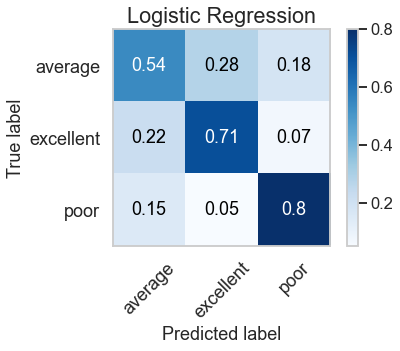

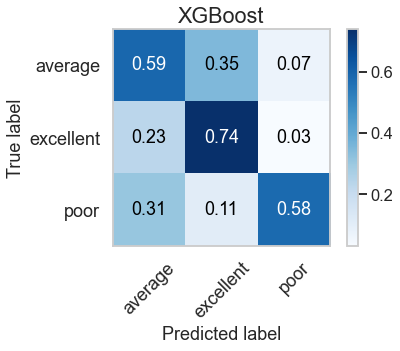

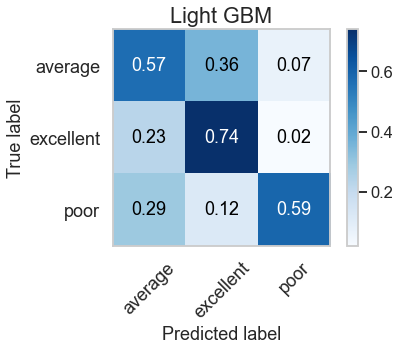

In [510]:
# cm = confusion_matrix(y_test, lr_test_preds, x_tick_rotation=45)

# cm_matrix = pd.DataFrame(data=cm, columns=['Actual Poor', 'Actual Average', 'Actual Excellent'], 
#                          index=['Predict Poor', 'Predict Average', 'Predict Excellent'])

# sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu').set_title('LR')

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, lr_test_preds, x_tick_rotation=45, normalize=True, title='Logistic Regression')
skplt.metrics.plot_confusion_matrix(y_test, xg_test_preds, x_tick_rotation=45, normalize=True, title='XGBoost')
skplt.metrics.plot_confusion_matrix(y_test, gbm_test_preds, x_tick_rotation=45, normalize=True, title='Light GBM')


plt.show()

[Text(0, 0.5, 'Average'), Text(0, 1.5, 'Excellent'), Text(0, 2.5, 'Poor')]

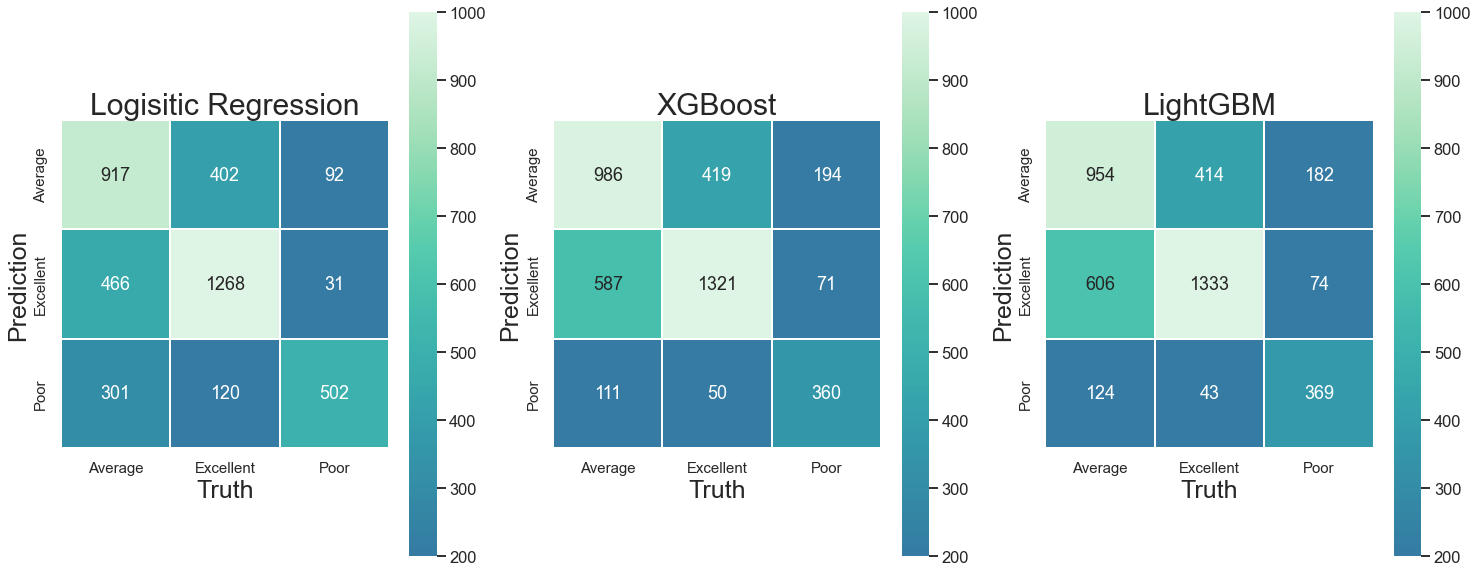

In [511]:
sns.color_palette("viridis", as_cmap=True)
# sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

# plot random forest confusion matrix
sns.heatmap(confusion_matrix(y_test, lr_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[0]).set_title('Logisitic Regression', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[0].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot xgboost confusion matrix
sns.heatmap(confusion_matrix(y_test, xg_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[1]).set_title('XGBoost', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[1].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)

# plot LightGBM confusion matrix
sns.heatmap(confusion_matrix(y_test, gbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cmap="mako",
            ax=ax[2]).set_title('LightGBM', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Average', 'Excellent', 'Poor'], fontsize=15)
ax[2].set_yticklabels(['Average', 'Excellent', 'Poor'], va='center', fontsize=15)